![picture](https://whyr.pl/2022/turkey/assets/images/logo200.png)


---


# <center>Webinar: Deep Learning using R
<center>Krystian Zieliński, 15.04.2022</center>

We're gonna cover following topics:


*   How DNN works
*   Introduction to tensorflow keras in R
*   Basic exaple
*   Explainability with DALEX
*   Sooo many parameters



In [1]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] fansi_1.0.3     utf8_1.2.2      digest_0.6.29   crayon_1.5.1   
 [5] IRdisplay_1.1   repr_1.1.4      lifecycle_1.0.1 jsonlite_1.8.0 
 [9] evaluate_0.15   pillar_1.7.0    rlang_1.0.2     cli_3.2.0      
[13] uuid_1.0-4      vctrs_0.4.0     ellipsis

In [2]:
install.packages("keras")
install.packages("DALEX")
install.packages("plot3D")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gridExtra’, ‘iBreakDown’, ‘ingredients’




In [3]:
library(keras)
library(tensorflow)
library(dplyr)
library(DALEX)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Welcome to DALEX (version: 2.4.0).
Find examples and detailed introduction at: http://ema.drwhy.ai/
Additional features will be available after installation of: ggpubr.
Use 'install_dependencies()' to get all suggested dependencies


Attaching package: ‘DALEX’


The following object is masked from ‘package:dplyr’:

    explain




Let's start with generating different datasets.

In [4]:
linear <-function(x,a=NA,b=NA){
  if(is.na(a)&is.na(b)){
    a = runif(1,min = -5,max = 5)
    b = runif(1,min = -5,max = 5)
  }
  return(a*x+b)
}

sample_linear<-  function(npoints, radius = 1,random_state=42,normalize=TRUE,noise = TRUE){
  set.seed(random_state)
  x = runif(npoints)
  y = linear(x)
  dataset = data.frame(list(x,y))
  colnames(dataset) = c('x','y')
  return(dataset)
} 

sample_spherical<-  function(npoints, radius = 1,random_state=42,normalize=TRUE,noise = TRUE){
  set.seed(random_state)
  theta = runif(1000, min = 0, max = 2*pi)
  x = radius * cos(theta) + runif(npoints,0,0.1)
  y = radius * sin(theta) + runif(npoints,0,0.1)
  z = tanh(sqrt(abs(x*y)))
  dataset = data.frame(list(x,y,z))
  colnames(dataset) = c('x_1','x_2','y')
  return(dataset)
}


sample_sinusoid<-function(npoints,random_state=42){
  set.seed(random_state)
  x = seq(0,4*pi,length.out = npoints)-runif(npoints,max = 0.1)
  set.seed(random_state-1)
  y = sin(x)+runif(npoints,max = 0.2)
  dataset = data.frame(list(x,y))
  colnames(dataset) = c('x','y')
  return(dataset)
}



sample_groups <- function(npoints,random_state = 42){
  set.seed(random_state)
  g1 = 0.8 * runif(npoints) + 15
  g2 = 5 * seq(0,1,length.out = npoints) -10 + 1.5*runif(npoints)
  g3 = 20 * sin(seq(0,1,length.out = npoints)) - 3.5*runif(npoints)
  x = c(g1,g2,g3)
  y = sin(seq(0,15,length.out = 3*npoints))
  z = ((x*y)>mean(x*y))*1
  dataset = data.frame(list(x,y,z))
  colnames(dataset) = c('x_1','x_2','y')
  return(dataset)
}

sample_multifeature <- function(npoints,n_features,noise_ratio = 0.8,correlated_features_ratio = 0.8,random_state = 42){
  set.seed(random_state)
  function_list = c(asin,acos,atan, atanh, log, sqrt, linear)
  n_correlated_features = round(n_features*correlated_features_ratio)
  output = sin(seq(0,4*pi,length.out = npoints)-runif(npoints,max = 0.1))
  
  values = vector(mode = "list", length = n_features+1)
  for(i in 1:n_correlated_features){
    sel_fn = function_list[[sample(1:6, 1)]]
    values[[i]] = sel_fn(output)
    values[[i]] = (values[[i]]-min(values[[i]]))/(max(values[[i]])-min(values[[i]])) + runif(npoints)*noise_ratio
  }
  for(i in ((n_correlated_features/2)+1):n_correlated_features){
    values[[i]] = linear(values[[i]] * values[[1+n_correlated_features-i]])
  }
  for(i in (n_correlated_features+1):n_features){
    sel_fn = function_list[[sample(1:6, 1)]]
    values[[i]] = sel_fn(runif(npoints))+runif(npoints)*noise_ratio
  }
  values[[length(values)]] = output
  dataset = data.frame(values)
  colnames(dataset) = c(paste0(rep('x_',length(n_features)),as.character(1:n_features)),'y')
  return(dataset)
}


sample_multifeature_cat <- function(npoints,n_features,noise_ratio = 0.8,correlated_features_ratio = 0.8,random_state = 42){
  set.seed(random_state)
  function_list = c(asin,acos,atan, atanh, log, sqrt, linear)
  n_correlated_features = round(n_features*correlated_features_ratio)
  output = abs(rbeta(n = npoints, shape1 = 5, shape2 =2.5) - runif(npoints))
  
  values = vector(mode = "list", length = n_features+1)
  for(i in 1:n_correlated_features){
    sel_fn = function_list[[sample(1:6, 1)]]
    values[[i]] = sel_fn(output)
    values[[i]] = (values[[i]]-min(values[[i]]))/(max(values[[i]])-min(values[[i]])) + runif(npoints)*noise_ratio
  }
  for(i in ((n_correlated_features/2)+1):n_correlated_features){
    values[[i]] = linear(values[[i]] * values[[1+n_correlated_features-i]])
  }
  for(i in (n_correlated_features+1):n_features){
    sel_fn = function_list[[sample(1:6, 1)]]
    values[[i]] = sel_fn(runif(npoints))+runif(npoints)*noise_ratio
  }
  
  output = cut(output, breaks = quantile(output), labels = c(0,1,2,3),include.lowest = T)
  
  values[[length(values)]] = output
  dataset = data.frame(values)
  colnames(dataset) = c(paste0(rep('x_',length(n_features)),as.character(1:n_features)),'y')
  return(dataset)
}

# How DNN works

## Feedforward

![picture](https://drive.google.com/uc?id=1ivl48t2YshkgIkZNhXVq8VQTCt7_Brpw)

## Backpropagation - zmienić indeksy

![picture](https://drive.google.com/uc?id=1mZEtRpaBDkCdx1I2UIq1OQ8VJqDnsf3k)

# Introduction to tensorflow keras in R

In [ ]:
### Create keras model object

model <- keras_model_sequential() %>% # Initiate model (https://tensorflow.rstudio.com/reference/keras/keras_model_sequential/)
  layer_dense( # First added dense (https://tensorflow.rstudio.com/reference/keras/layer_dense/)
    units: 'int', # Number of neurons in the layer
    activation: "str", # Activation function (https://tensorflow.rstudio.com/reference/keras/#section-activations)
    ... # Tons of different arguments, check out the "regulizers" to prevent overfitting and "trainable" to freeze layers in transfer learning
    input_shape: 'int' # Argument passed in the first layer - dimenstionality of the dataset
    ) %>% 
  layer_dropout( # Dropout layer - part of neurons are not connected
    rate: 'float'
    )%>% 
  layer_dense( # Next layer, same arguments - but without input shape
    units: 'int',
    activation: "str",
    ...
    ) %>%
  ... # Add as many layers as needed
    ) %>%
  layer_dense( # Last layer
    units = 1, # Number of neurons has to be equal to dimensionality of y (1 for regression, 1 for binary classification, n for n-class classification)
    activation: "str" # Last activation function should be selected for the task (linear for regression, sigmoid for classification, softmax for n-class classification)
    )


model %>% 
  compile( # Compiling the model
    loss: 'str', # loss function - depending on type of task (https://tensorflow.rstudio.com/reference/keras/#section-losses)
    optimizer: 'optimizer_function'( # The algorithm used to minimalize loss (https://tensorflow.rstudio.com/reference/keras/#section-optimizers)
      learning_rate: 'float' # Ratio of updating weights and biases
    ),
    metrics: 'list' # List of observed metrics (https://tensorflow.rstudio.com/reference/keras/#section-metrics)
  )

In [ ]:
history <- model %>% fit( # Training the model (https://tensorflow.rstudio.com/reference/keras/fit.keras.engine.training.model/)
  x: 'matrix', # Train dataset
  y: 'matrix', # Train label
  epochs: 'int', # Number of iterations
  validation_split: 'float' # Percent of observations in validation subset
  callbacks: 'callback' # List of callbacks (e.g. early stopping)
  class_weight: 'dict' # Used for classification of unbalanced data 
  sample_weight: 'matrix' # If some observations should update weights more
)

# Some utils

In [5]:
split_data <-function(df, split_fraction=0.8){  
  train_ids    <- sort(sample(seq_len(nrow(df)), size=round(nrow(df) * split_fraction)))
  df_train   <- df[train_ids, ]
  df_test <- df[-train_ids, ]
  return(list("df_train"=df_train,"df_test"=df_test))
}

# Basic exaple - regression

## Example 1

In [6]:
df = sample_linear(1000)

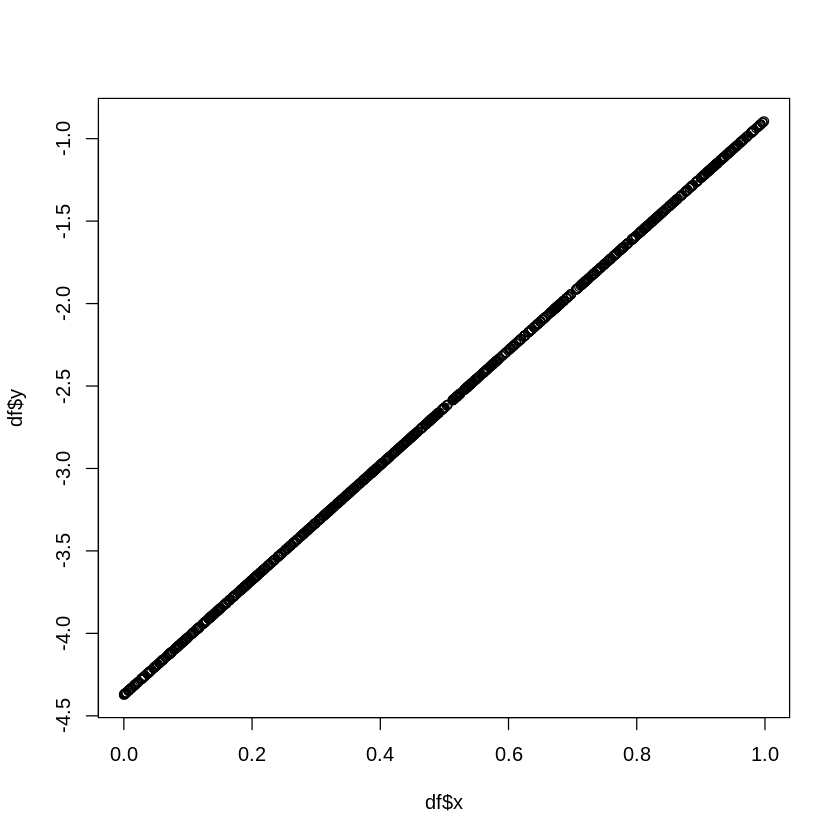

In [7]:
plot(df$x,df$y)

In [8]:
df = split_data(df)

In [9]:
model <- keras_model_sequential() %>% 
  layer_dense(
    units = 1,
    activation = "linear",
    input_shape = c(ncol(df$df_train)-1)
  )


model %>% 
  compile(
    loss = "mse",
    optimizer = optimizer_sgd(),
    metrics = list("mean_absolute_error")
  )

Loaded Tensorflow version 2.8.0



In [10]:
history <- model %>% fit(
  x = df$df_train %>% select(-y)%>% as.matrix(),
  y = df$df_train$y,
  epochs = 10,
  validation_split = 0.2
)

`geom_smooth()` using formula 'y ~ x'



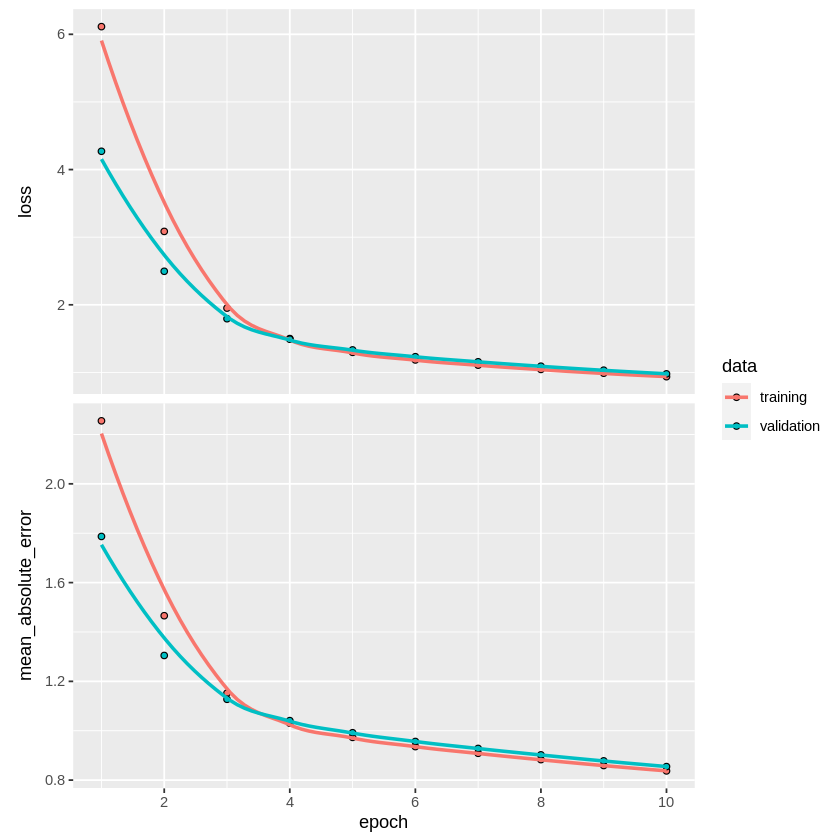

In [11]:
plot(history)

In [12]:
predicted_values = model %>% predict(df$df_test %>% select(-y)%>% as.matrix())

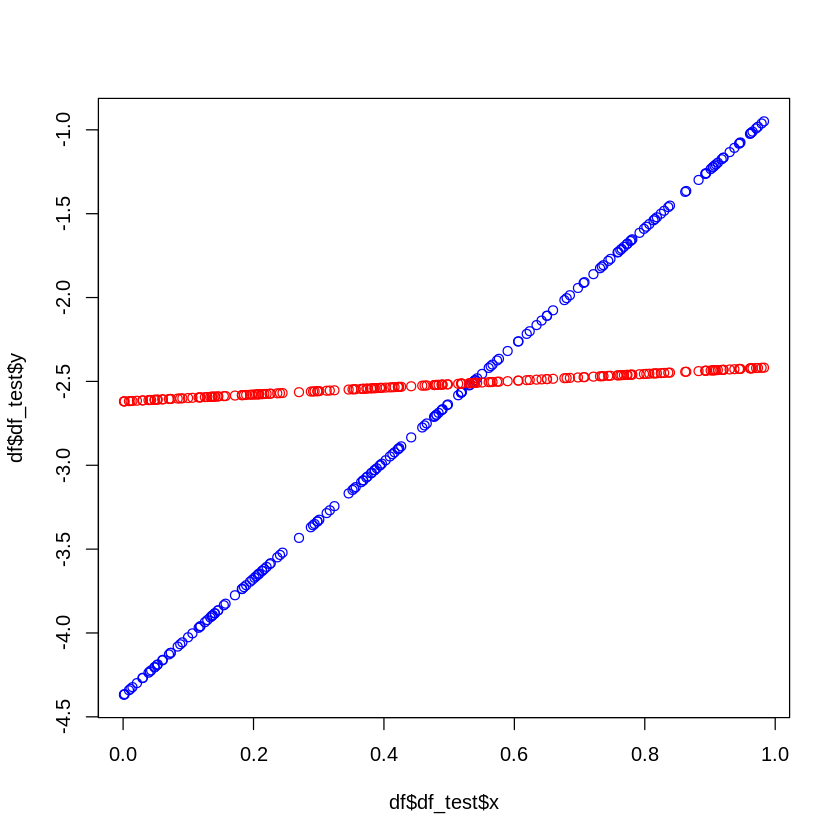

In [13]:
plot(df$df_test$x, df$df_test$y, col='blue')
points(df$df_test$x, predicted_values, col = 'red')

Could be better - try to train the model for 100 iterations

## Example 2

In [14]:
df = sample_sinusoid(1000)

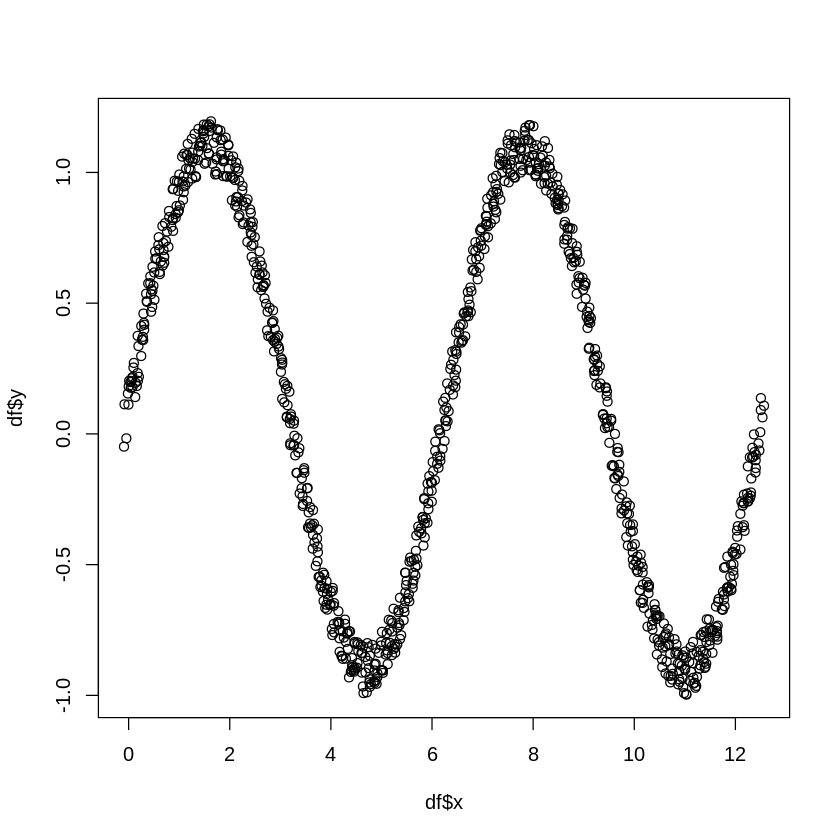

In [15]:
plot(df$x,df$y)

In [16]:
df = split_data(df)

In [37]:
model <- keras_model_sequential() %>% 
  layer_dense(
    units = 128,
    activation = "relu",
    input_shape = c(ncol(df$df_train)-1)
  )%>%
  layer_dense(
    units = 64,
    activation = "relu"
  )%>%
  layer_dense(
    units = 32,
    activation = "relu"
  )%>%
  layer_dense(
    units = 16,
    activation = "relu"
  )%>%
  layer_dense(
    units = 1,
    activation = "linear"
  )

model %>% 
  compile(
    loss = "mse",
    optimizer = optimizer_sgd(
      learning_rate = 0.01,
      decay = 0
    ),
    metrics = list("mean_absolute_error")
  )

In [38]:
history <- model %>% fit(
  x = df$df_train %>% select(-y)%>% as.matrix(),
  y = df$df_train$y,
  epochs = 50,
  validation_split = 0.2
)

`geom_smooth()` using formula 'y ~ x'



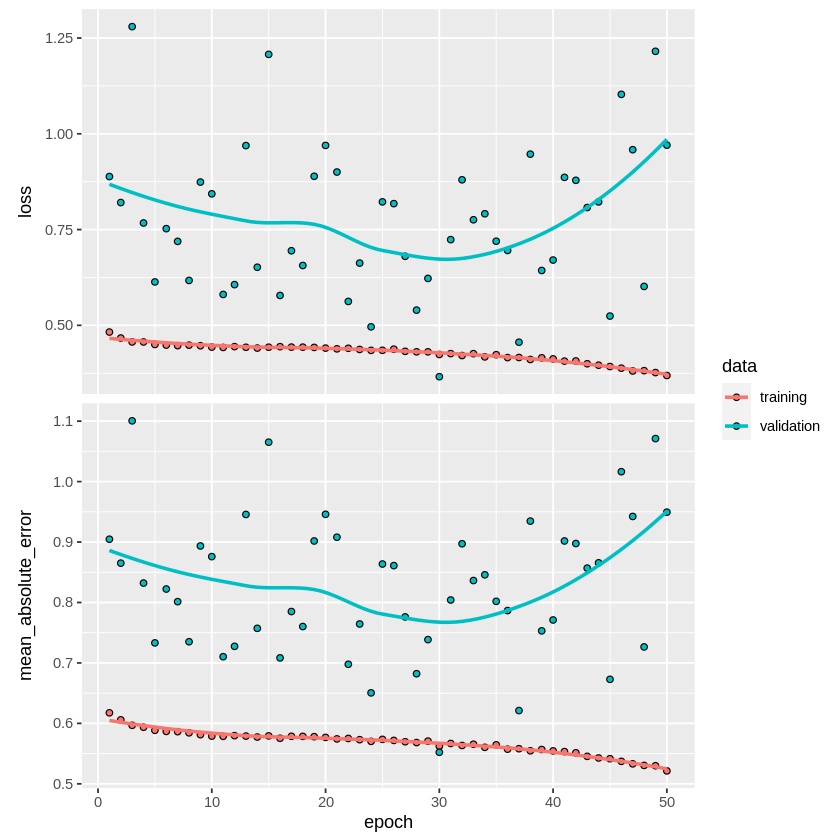

In [39]:
plot(history)

In [40]:
predicted_values = model %>% predict(df$df_test %>% select(-y)%>% as.matrix())

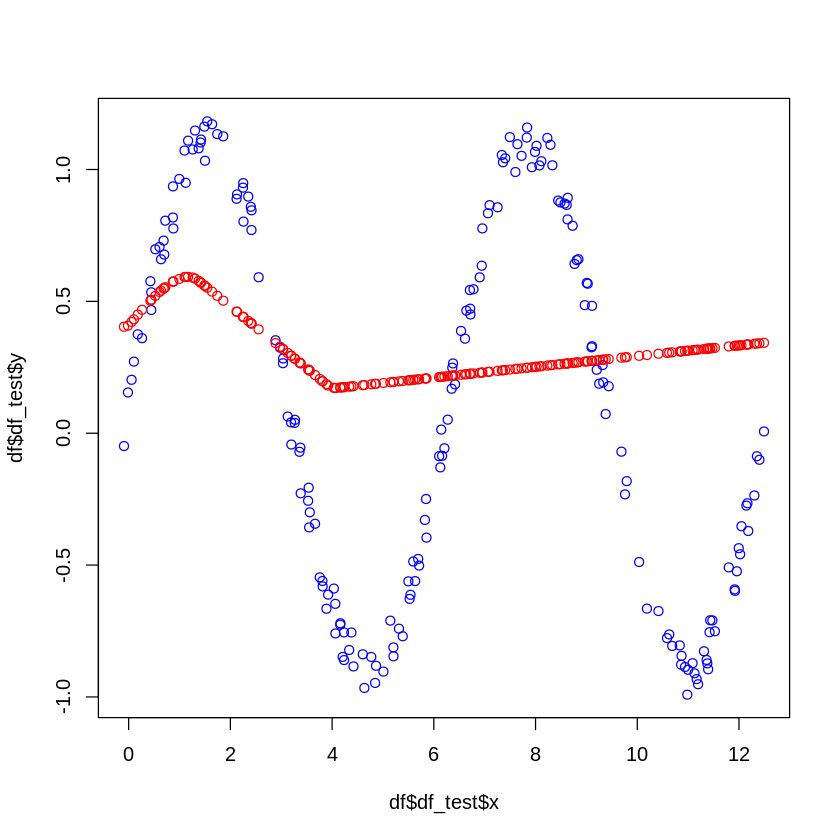

In [41]:
plot(df$df_test$x, df$df_test$y, col='blue')
points(df$df_test$x, predicted_values, col = 'red')

That's definetely not what we're looking for. It seems that our network is a slow-learner - so let's play with the parameters:


1.   Increase learning_rate
2.   Change optimizer to optimizer_adam()

Conclusions?

Try at home - 5 layers with number of neurons 128-64-32-16-1 and sgd(0.005)


## Example 3

In [43]:
library(plot3D)

Warning message:
“no DISPLAY variable so Tk is not available”


In [44]:
df = sample_spherical(1000)

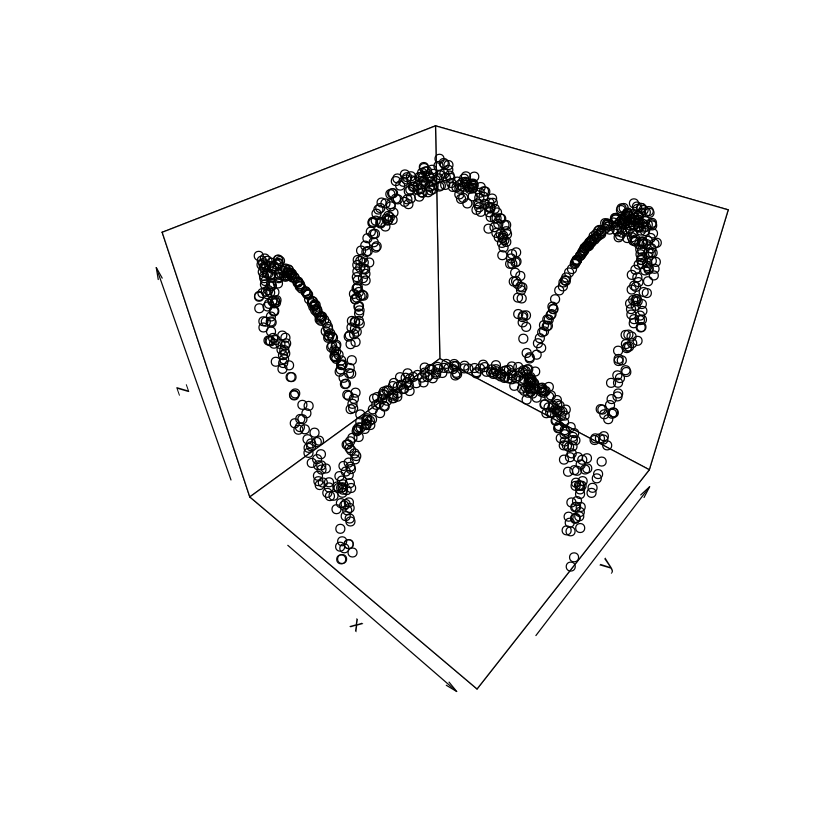

In [48]:
scatter3D(df$x_1, df$x_2, df$y, clab = c("x_1", "x_2"), colvar = NULL)

In [49]:
df = split_data(df)

In [54]:
model <- keras_model_sequential() %>% 
  layer_dense(
    units = 128,
    activation = "relu",
    input_shape = c(ncol(df$df_train)-1)
  )%>%
  layer_dense(
    units = 64,
    activation = "relu"
  )%>%
  layer_dense(
    units = 32,
    activation = "relu"
  )%>%
  layer_dense(
    units = 1,
    activation = "linear"
  )


model %>% 
  compile(
    loss = "mse",
    optimizer = optimizer_adam(learning_rate = 0.001),
    metrics = list("mean_absolute_error")
  )

In [55]:
early_stop = callback_early_stopping(
      monitor = "val_loss",
      min_delta = 0.001,
      patience = 30,
      verbose = 0,
      mode = "min",
      restore_best_weights = TRUE
    )

In [56]:
history <- model %>% fit(
  x = df$df_train %>% select(-y)%>% as.matrix(),
  y = df$df_train$y,
  epochs = 100,
  validation_split = 0.2,
  callbacks = list(early_stop)
)

`geom_smooth()` using formula 'y ~ x'



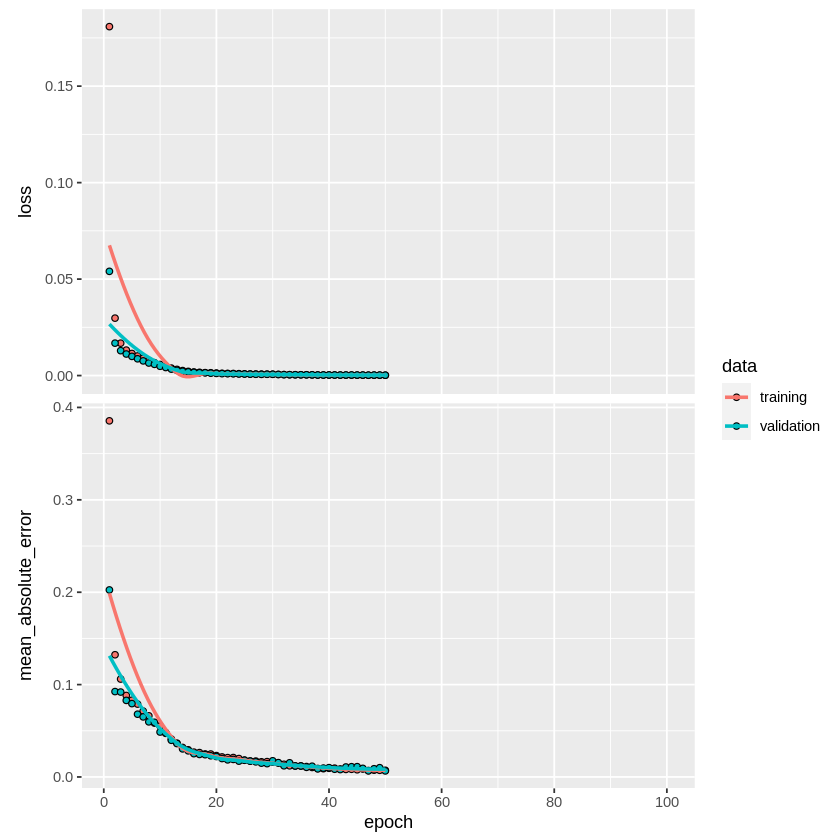

In [57]:
plot(history)

In [58]:
predicted_values = model %>% predict(df$df_test %>% select(-y)%>% as.matrix())

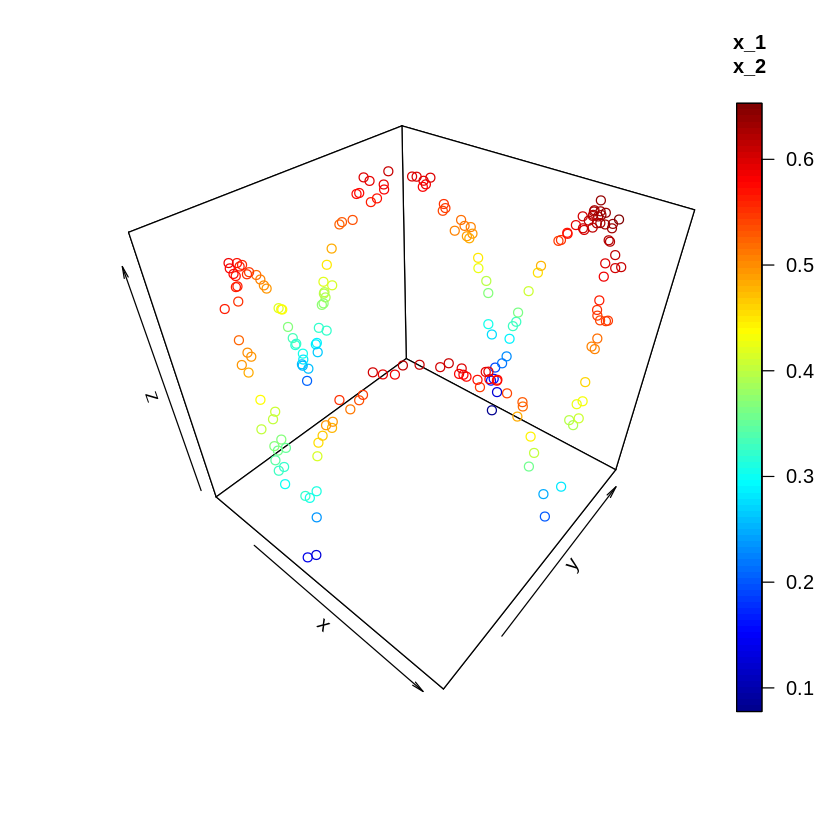

In [59]:
scatter3D(df$df_test$x_1, df$df_test$x_2, df$df_test$y, clab = c("x_1", "x_2"))

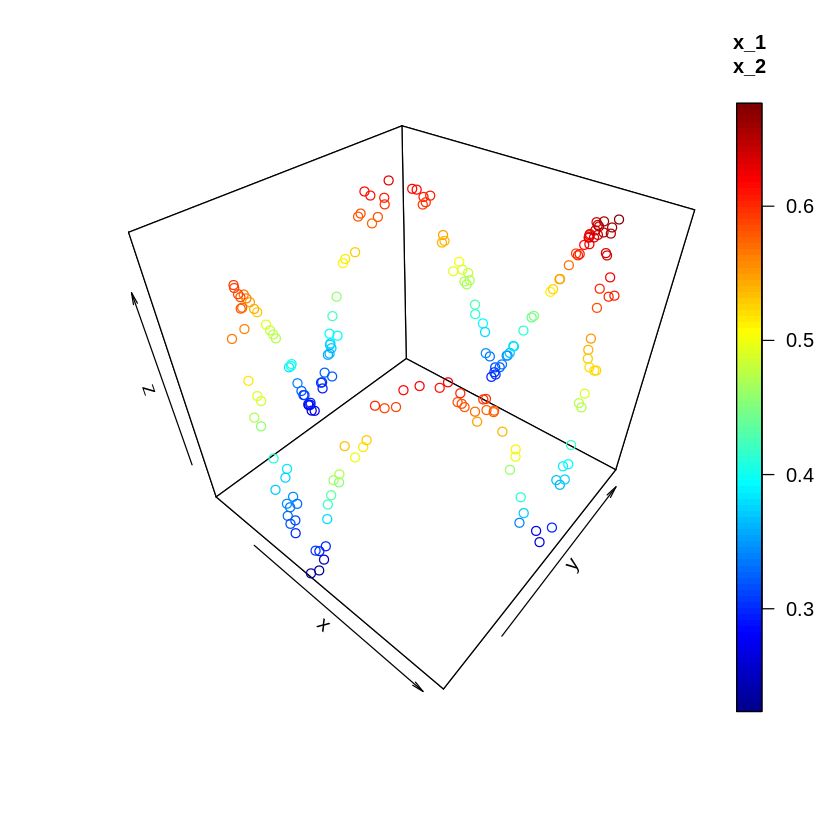

In [60]:
scatter3D(df$df_test$x_1, df$df_test$x_2, predicted_values, clab = c("x_1", "x_2"))

And now the other way around - try SGD

## Explainability with DALEX

In [61]:
explainer = DALEX::explain(model = model,
                           data = df$df_test %>%select(-y)%>%as.matrix(),
                           y = df$df_test$y,
                           type = "regression",
                           label = "Keras model",
                           colorize = FALSE)

Preparation of a new explainer is initiated
  -> model label       :  Keras model 
  -> data              :  200  rows  2  cols 
  -> target variable   :  200  values 
  -> predict function  :  yhat.default will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package Model of class: keras.engine.sequential.Sequential package unrecognized , ver. Unknown , task regression (  default  ) 
  -> model_info        :  type set to  regression 
  -> predicted values  :  numerical, min =  0.2234577 , mean =  0.479737 , max =  0.6766739  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -0.2301886 , mean =  -0.0001512203 , max =  0.04071168  
  A new explainer has been created!  


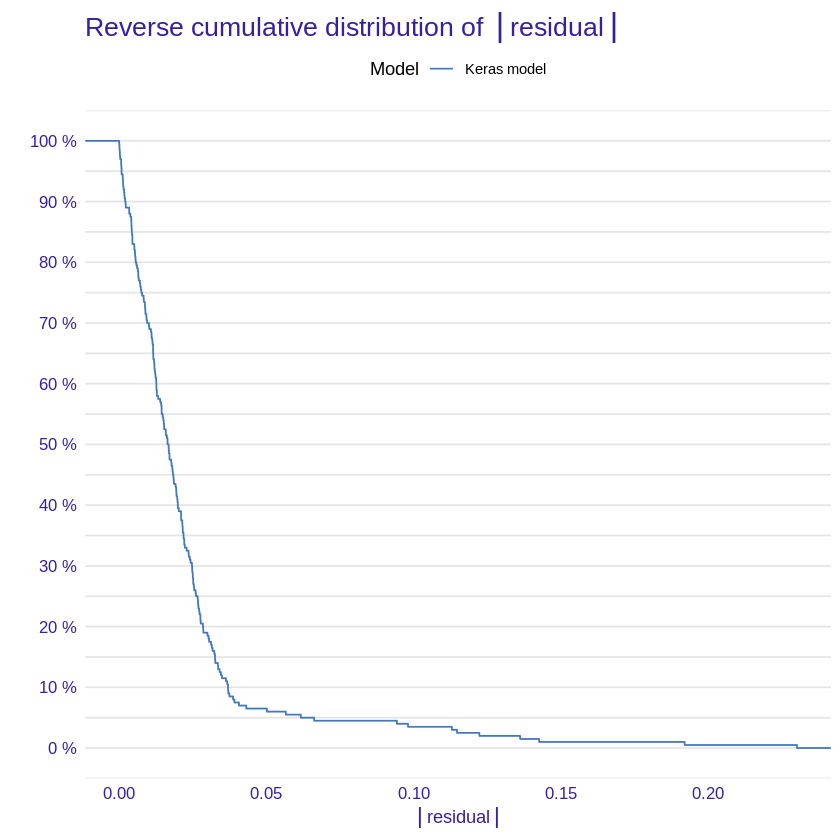

In [62]:
plot(model_performance(explainer))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



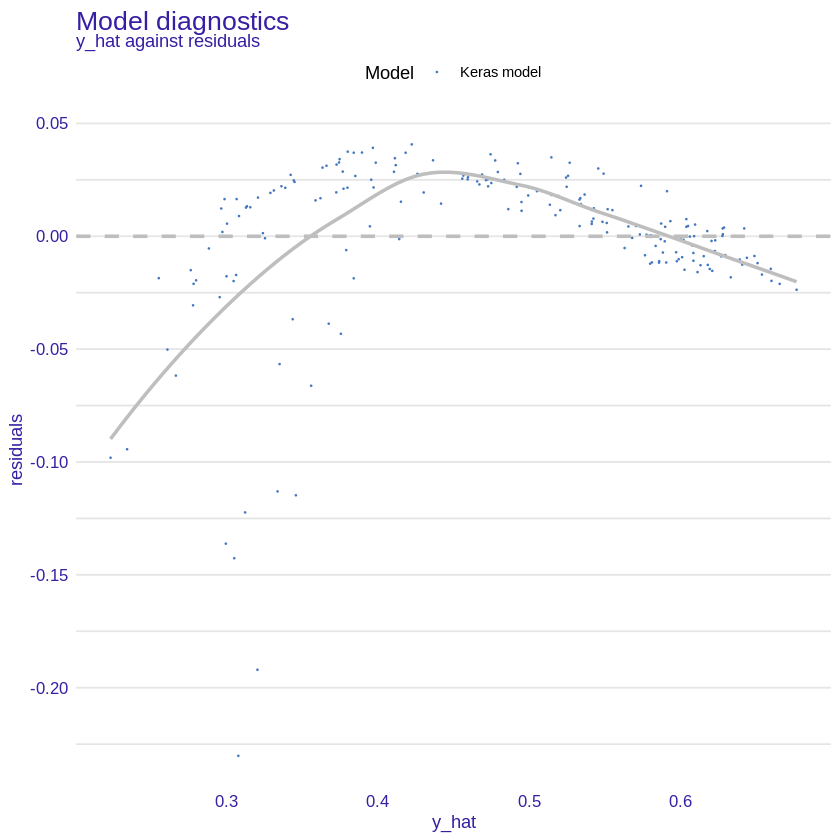

In [65]:
plot(model_diagnostics(explainer))

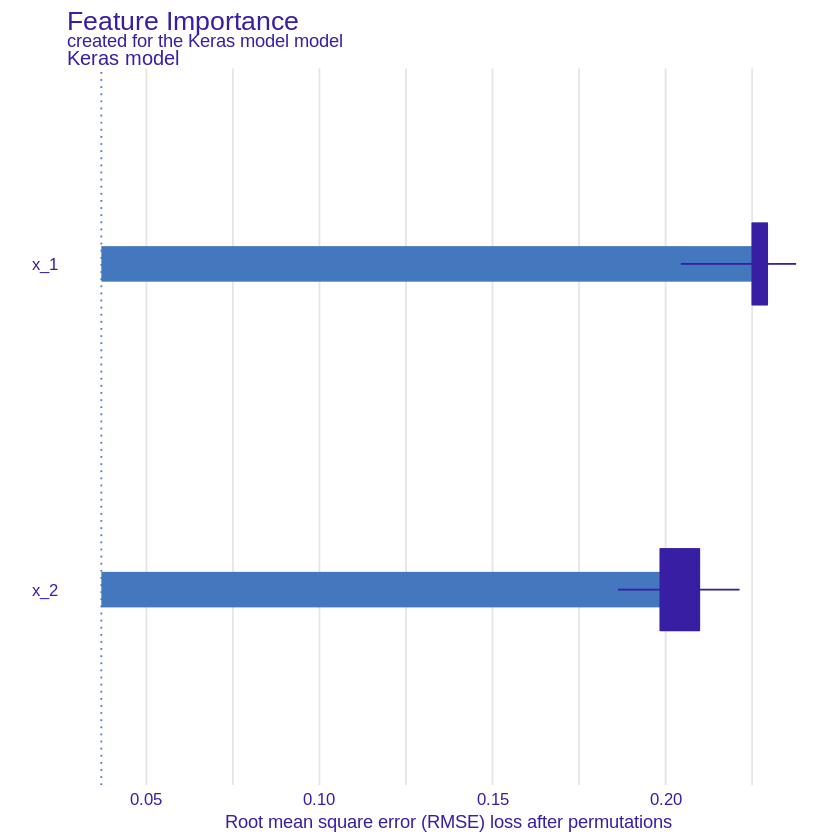

In [63]:
plot(model_parts(explainer))

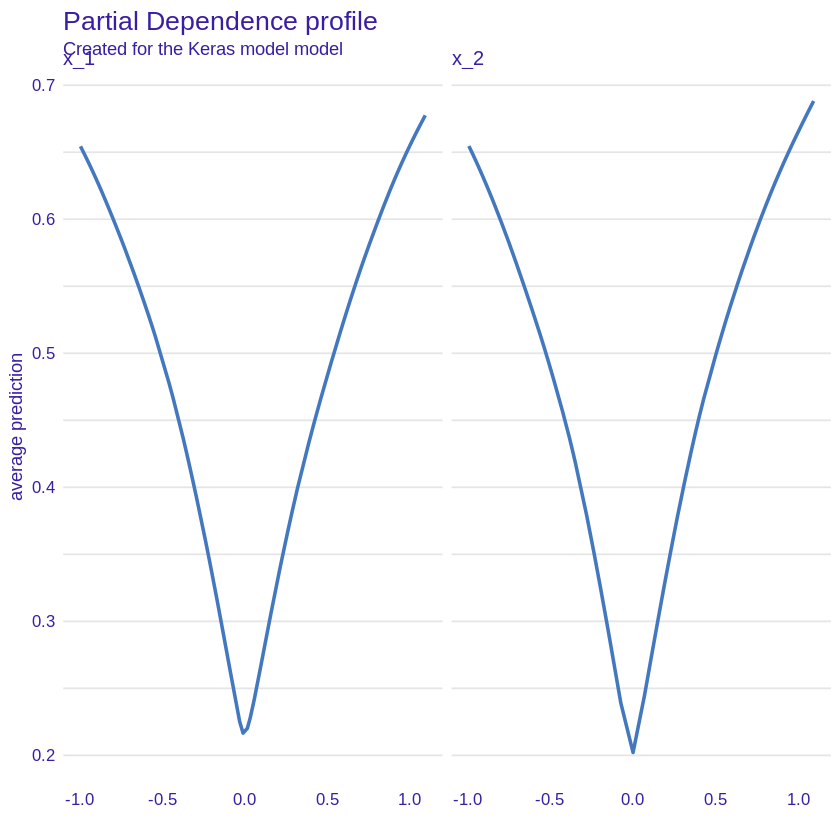

In [64]:
plot(model_profile(explainer))

# Classification

In [66]:
df = sample_groups(1000)

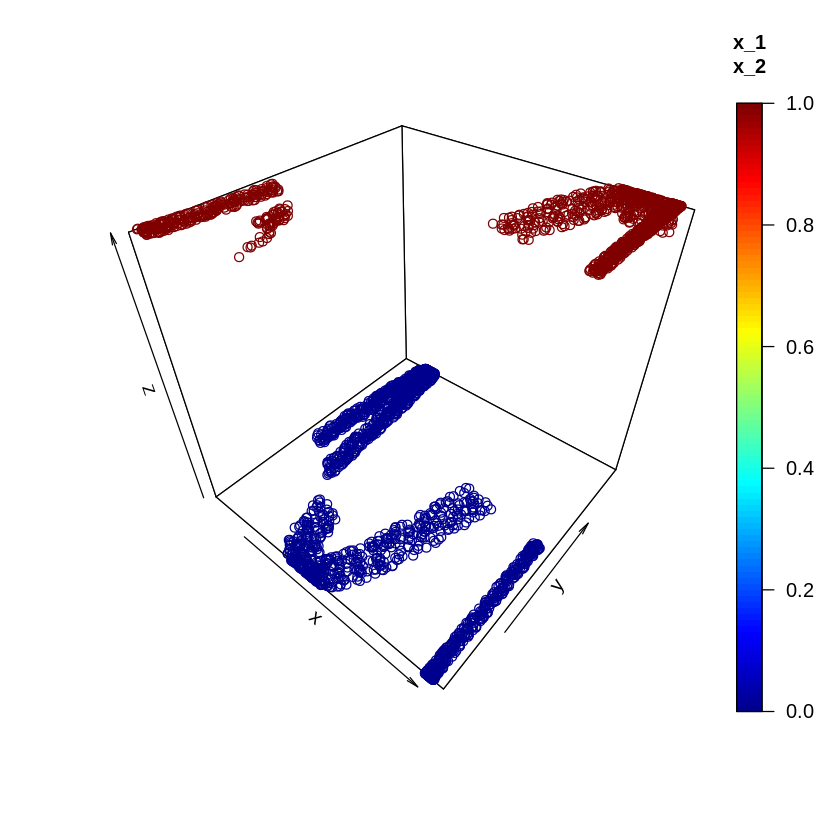

In [67]:
scatter3D(df$x_1, df$x_2, df$y, clab = c("x_1", "x_2"))

In [68]:
df = split_data(df)

In [69]:
model <- keras_model_sequential() %>% 
  layer_dense(
    units = 64,
    activation = "relu",
    input_shape = c(ncol(df$df_train)-1)
  )%>%
  layer_dense(
    units = 32,
    activation = "relu"
  )%>%
  layer_dense(
    units = 1,
    activation = "sigmoid"
  )


model %>% 
  compile(
    loss = "binary_crossentropy",
    optimizer = optimizer_adam(),
    metrics = list("accuracy")
  )


In [70]:
history <- model %>% fit(
  x = df$df_train %>% select(-y)%>% as.matrix(),
  y = df$df_train$y,
  epochs = 100,
  validation_split = 0.2,
  callbacks = list(
    callback_early_stopping(
      monitor = "val_loss",
      min_delta = 0.001,
      patience = 10,
      verbose = 0,
      mode = "min",
      restore_best_weights = TRUE
    )
  )
)

`geom_smooth()` using formula 'y ~ x'



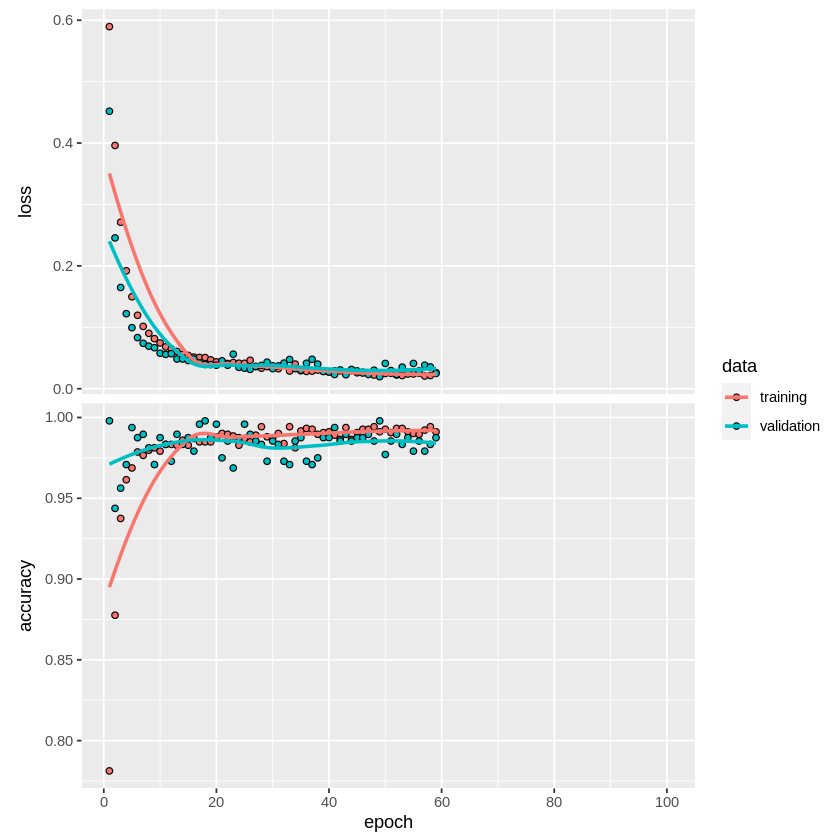

In [71]:
plot(history)

In [72]:
predicted_values = model %>% predict(df$df_test %>% select(-y)%>% as.matrix())

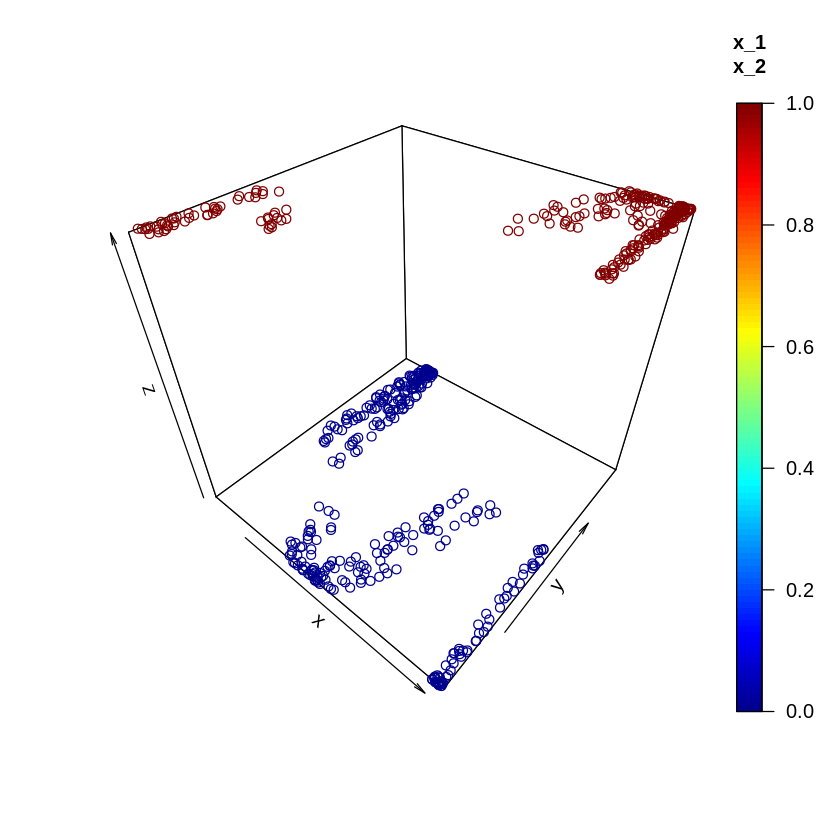

In [73]:
scatter3D(df$df_test$x_1, df$df_test$x_2, df$df_test$y, clab = c("x_1", "x_2"))

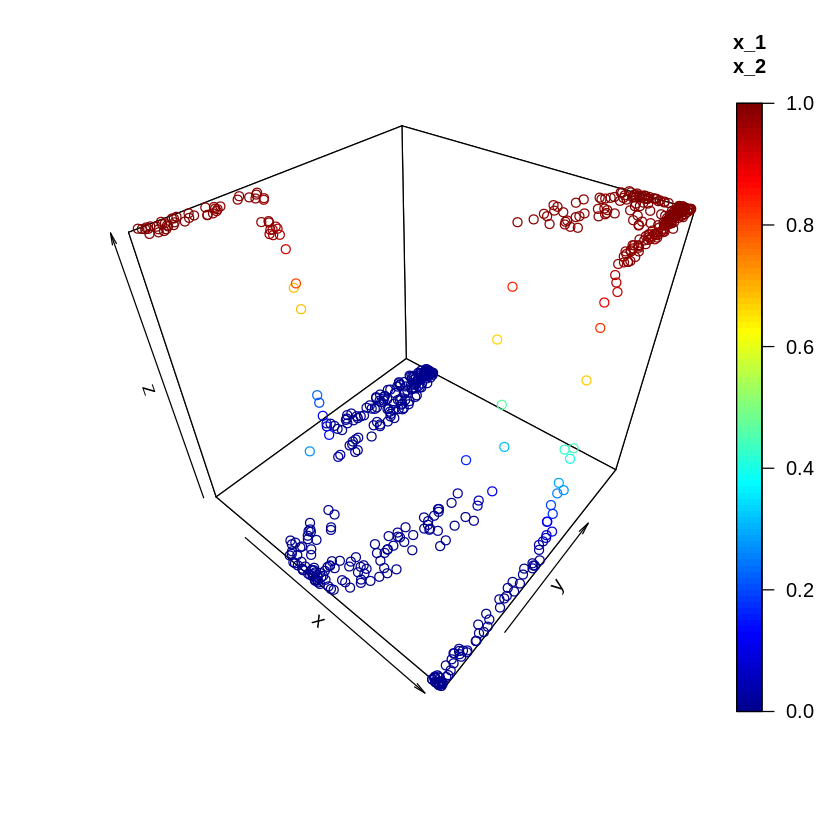

In [74]:
scatter3D(df$df_test$x_1, df$df_test$x_2, predicted_values, clab = c("x_1", "x_2"))

# Sooo many parameters

## Some more utils

In [75]:
build_reg_model <- function(optimizer,layers) {
  model <- keras_model_sequential()%>%
    layer_dense(units = layers[[1]][[1]],
                activation = layers[[1]][[2]])
  
  for(i in 2:length(layers)){
    model = model %>%
      layer_dense(units = layers[[i]][[1]], activation = layers[[i]][[2]])
  }
  model = model %>% 
    layer_dense(units = 1) 
  
  model %>% 
    compile(
      loss = "mse",
      optimizer = optimizer,
      metrics = list("mean_absolute_error")
    )
  
  return(model)
}

build_class_model <- function(optimizer,layers, n_classes) {
  model <- keras_model_sequential()%>%
    layer_dense(units = layers[[1]][[1]],
                activation = layers[[1]][[2]])
  
  for(i in 2:length(layers)){
    model = model %>%
      layer_dense(units = layers[[i]][[1]], activation = layers[[i]][[2]])
  }
  model = model %>% 
    layer_dense(
      activation = "softmax",
      units = n_classes) 
  
  model %>% 
    compile(
      loss = "categorical_crossentropy",
      optimizer = optimizer,
      metrics = list("categorical_accuracy")
    )
  
  return(model)
}

train_models <-function(models_params, df){
  models = vector(
    mode = "list", length = length(models_params)
  )
  names(models) = paste0(rep('model_',length(models_params)),as.character(1:length(models_params)))
  for(i in 1:length(models_params)){
    models[[i]] = list(
      model=NA,
      history= NA
    )
    models[[i]]$model = build_reg_model(models_params[[i]]$optimizer,models_params[[i]]$layers)
    
    models[[i]]$history<- models[[i]]$model %>% fit(
      x = df$df_train %>% select(-y)%>% as.matrix(),
      y = df$df_train$y,
      epochs = 50,
      validation_split = 0.2,
      callbacks = list(
        callback_early_stopping(
          monitor = "val_loss",
          min_delta = 0.01,
          patience = 10,
          verbose = 0,
          mode = "min",
          restore_best_weights = TRUE
        )
      )
    )
    
  }
  return(models)
}

select_by_metrics <- function(models,models_params){
  for(model in names(models)){
    print(model)
    print(models[[model]]$history)
  }
  for(metric_name in names(models[[model]]$history$metrics)){
    
  }
}


In [101]:
explain_models_dep <- function(models){
  explainers = vector(
    mode = "list", length = length(models)
  )
  names(explainers) = paste0(rep('explainer_',length(models)),as.character(1:length(models)))
  
  for(i in 1:length(models)){
    explainers[[i]] = list(
      explainer = NA,
      model_performance_value = NA,
      model_parts_value = NA
    )
    
    
    explainers[[i]]$explainer <- DALEX::explain(model = models[[i]]$model,
                                                data = df$df_test %>%select(-y)%>%as.matrix(),
                                                y = df$df_test$y,
                                                type = "regression",
                                                label = paste0("Keras model ",i),
                                                colorize = FALSE)
    explainers[[i]]$model_performance_value = model_performance(explainers[[i]]$explainer)
    explainers[[i]]$model_parts_value = model_parts(explainers[[i]]$explainer)
  }
  return(explainers)
}

explain_models <-function(models){
  explainers = list(
    explainer= vector(
      mode = "list", length = length(models)
    ),
    model_performance_value= vector(
      mode = "list", length = length(models)
    ),
    model_parts_value= vector(
      mode = "list", length = length(models)
    ),
    model_profile_value= vector(
      mode = "list", length = length(models)
    ),
    model_diagnostics_value= vector(
      mode = "list", length = length(models)
    )
  )
  for(i in 1:length(models)){
    explainers$explainer[[i]] <- DALEX::explain(model = models[[i]]$model,
                                                data = df$df_test %>%select(-y)%>%as.matrix(),
                                                y = df$df_test$y,
                                                type = "regression",
                                                label = paste0("Keras model ",i),
                                                colorize = FALSE)
    explainers$model_performance_value[[i]] = model_performance(explainers$explainer[[i]])
    explainers$model_parts_value[[i]] = model_parts(explainers$explainer[[i]])
    explainers$model_profile_value[[i]] = model_profile(explainers$explainer[[i]])
    explainers$model_diagnostics_value[[i]] = model_diagnostics(explainers$explainer[[i]])
    
  }
  return(explainers)
}

## Train multiple models

In [93]:
df = sample_multifeature(1000, 8, noise_ratio = 0.5, correlated_features_ratio = 0.5)

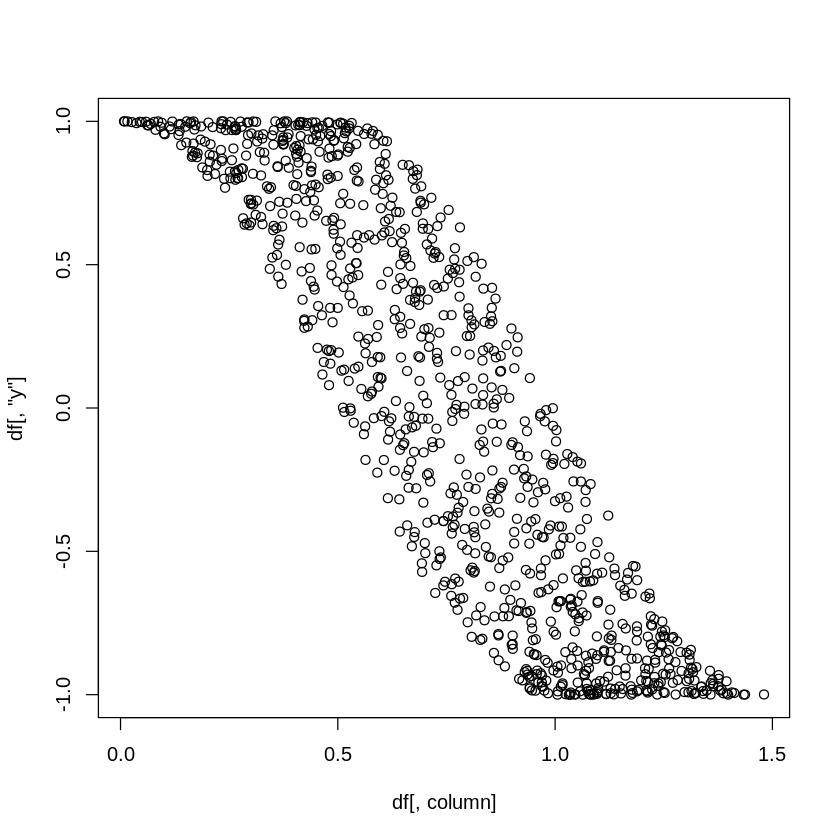

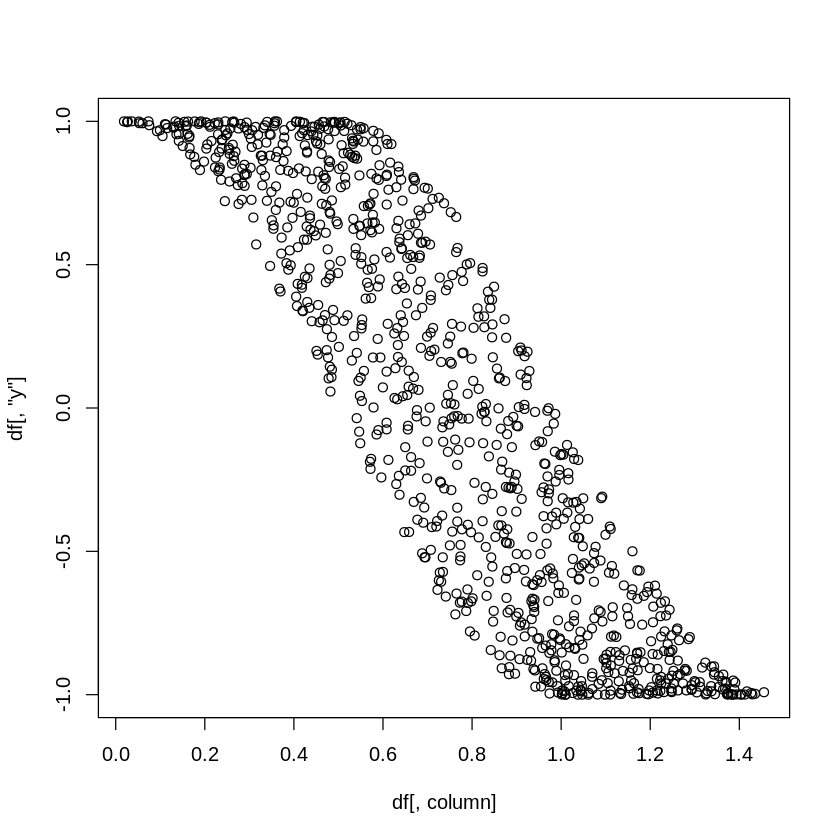

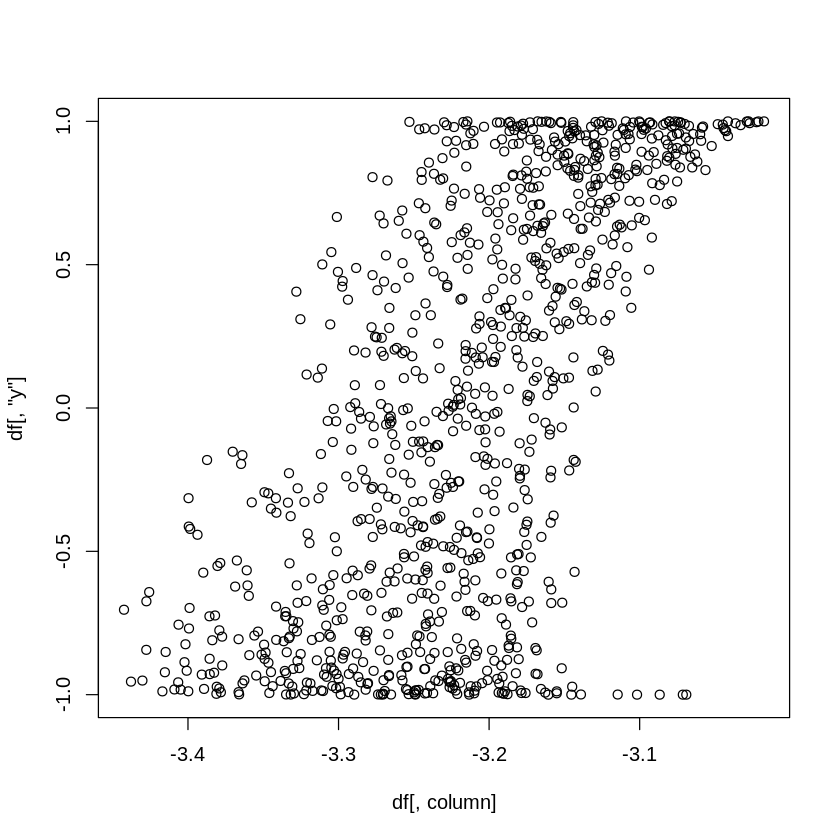

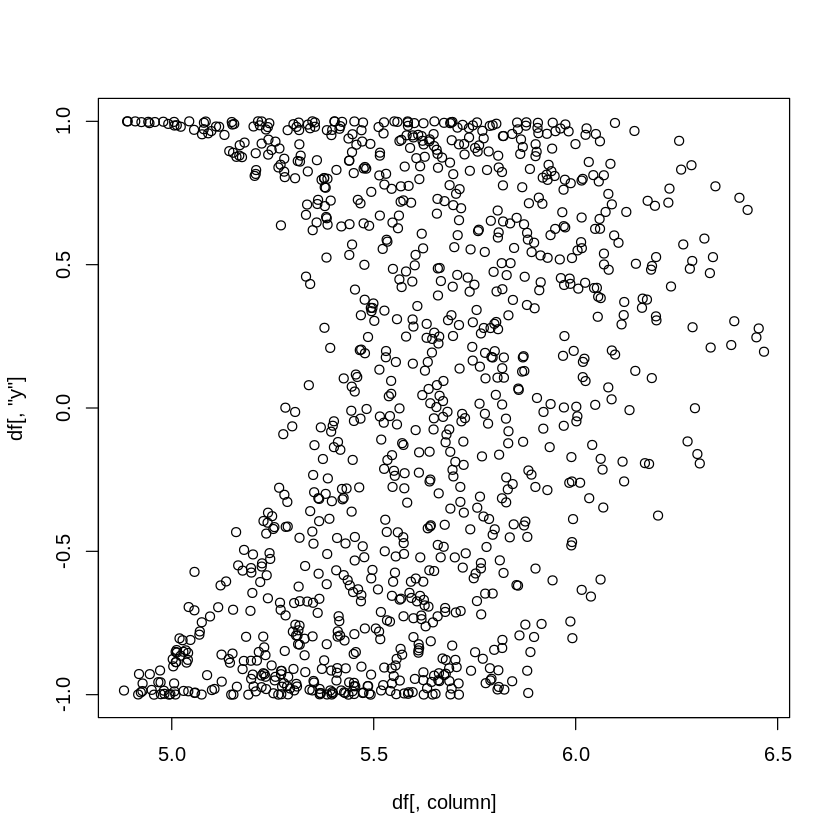

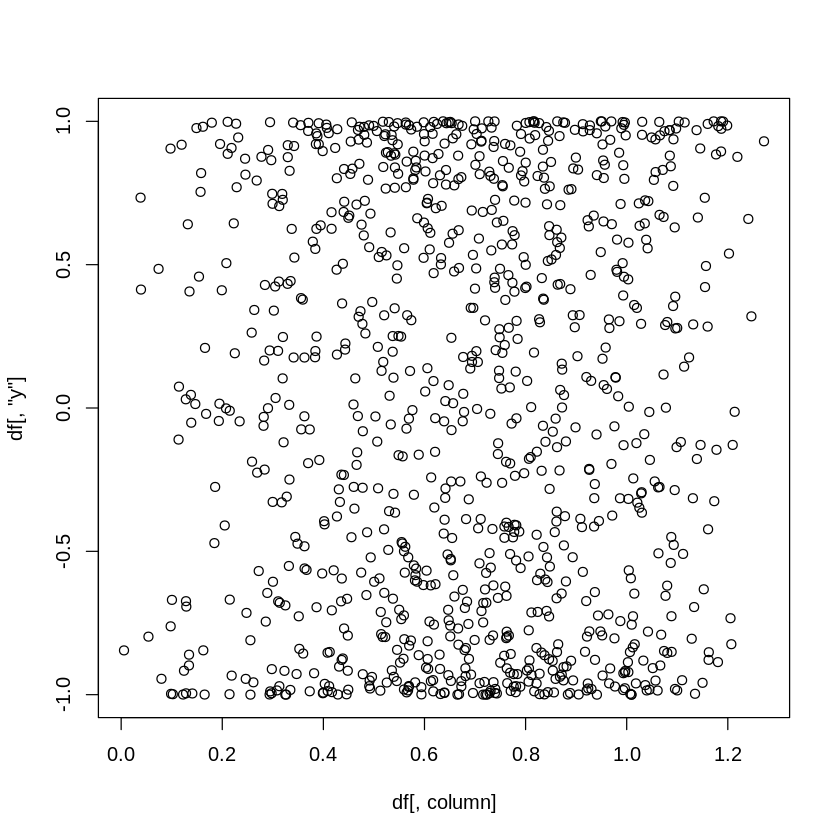

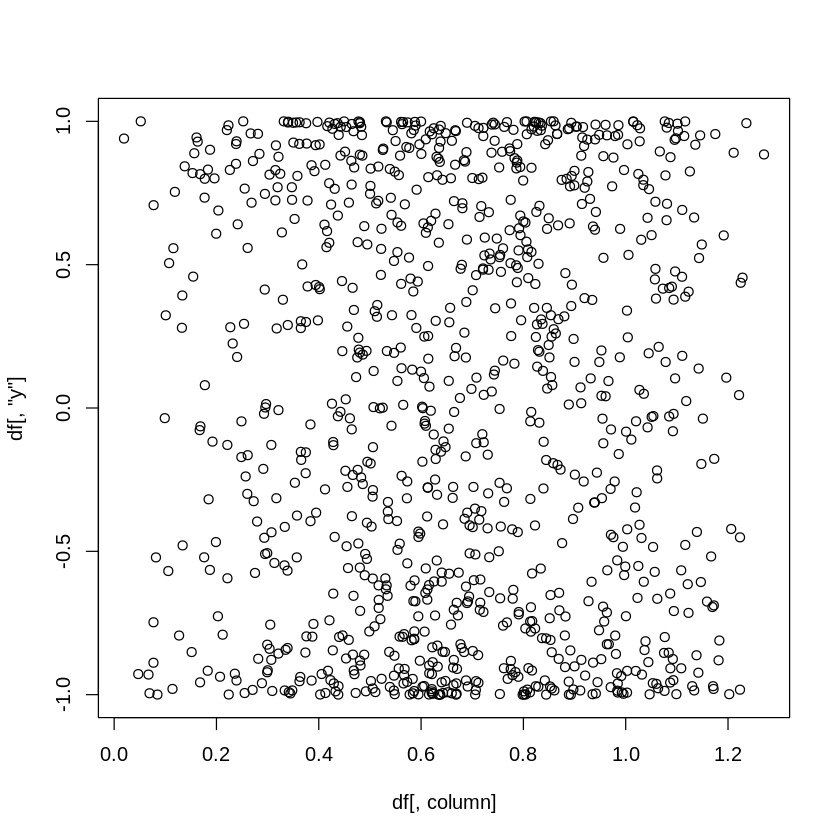

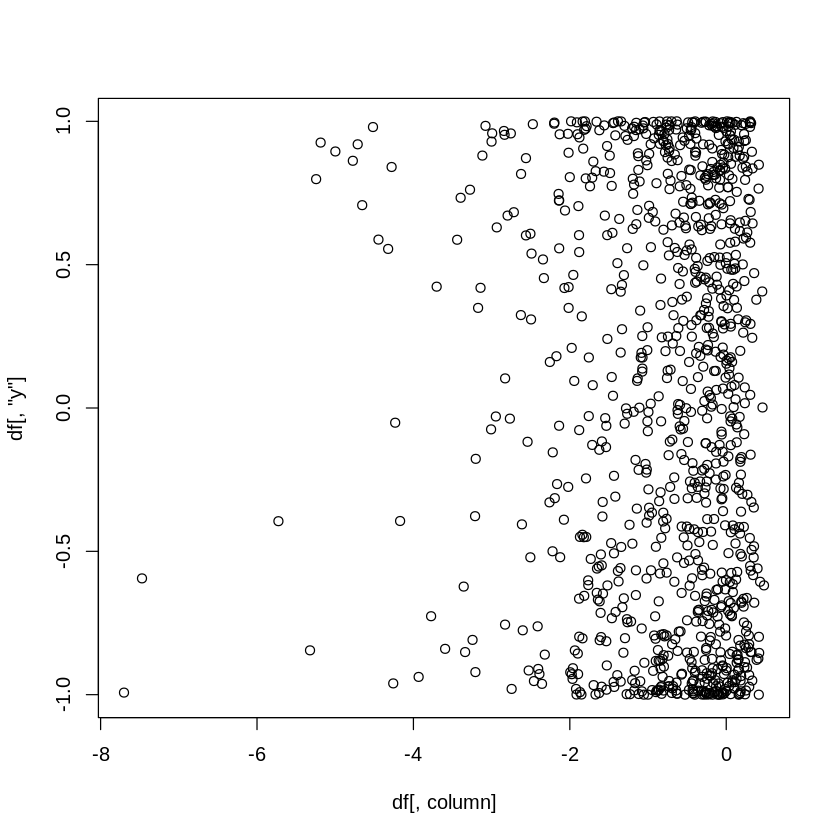

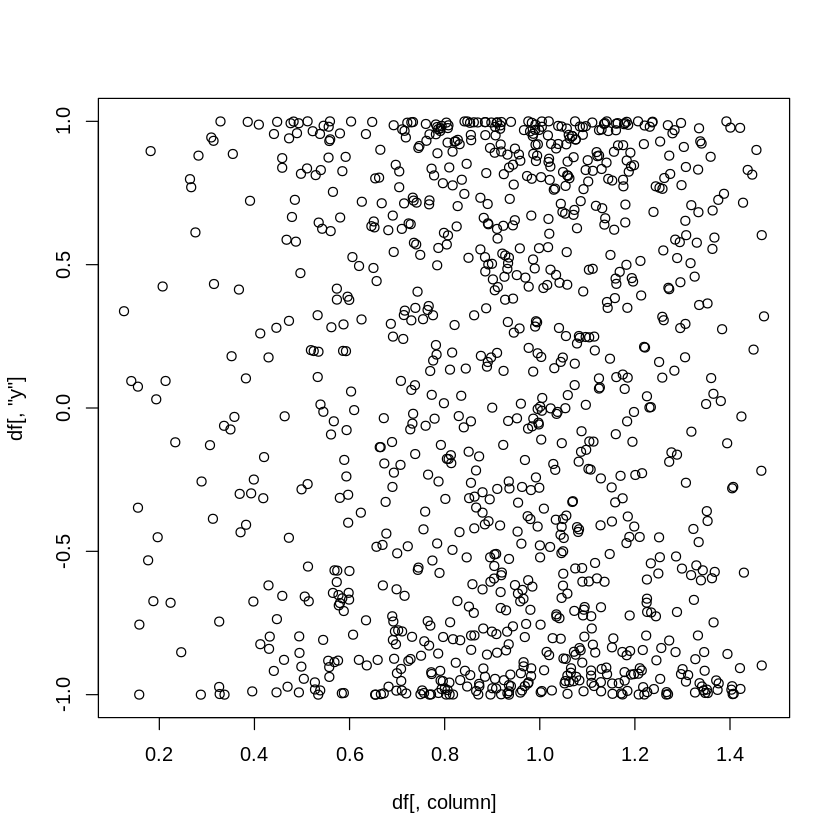

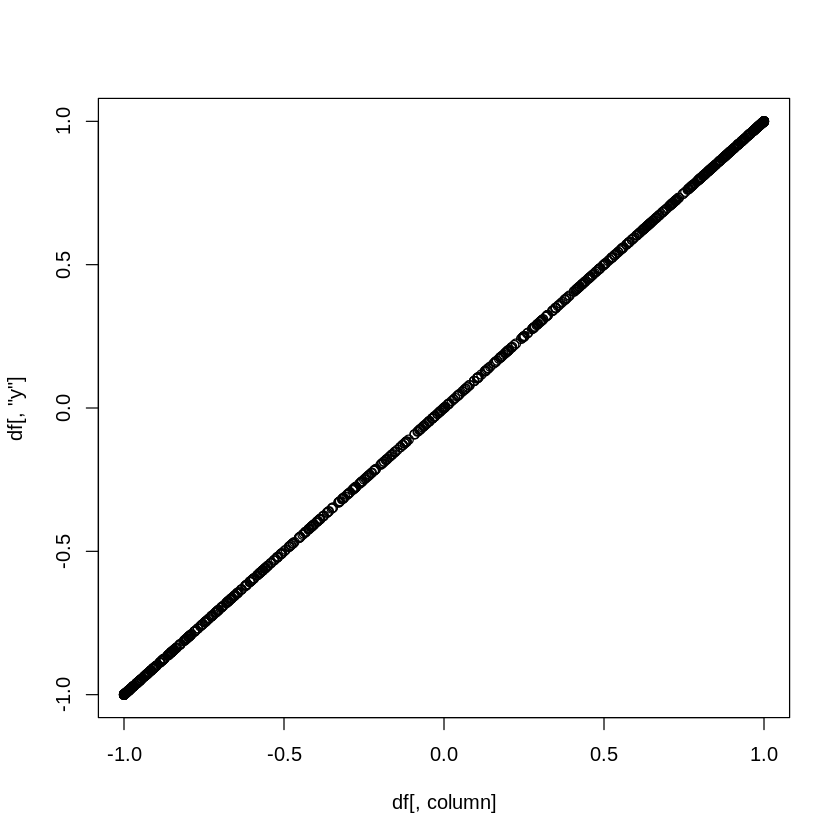

In [94]:
for( column in colnames(df)){
  plot(df[,column], df[,'y'])
}

In [95]:
models_params = list(
  model1 = list( # Group 1 - optimizers + relu
    optimizer = optimizer_adam(), 
    layers = list(
      layer1 = list(
        n_units = 64,
        activation_function = 'relu'
      ),
      layer2 = list(
        n_units = 32,
        activation_function = 'relu'
      )
    )
  ),
  model2 = list(
    optimizer = optimizer_sgd(),
    layers = list(
      layer1 = list(
        n_units = 64,
        activation_function = 'relu'
      ),
      layer2 = list(
        n_units = 32,
        activation_function = 'relu'
      )
    )
  ),# Group 2 - optimizers + sigmoid
  model3 = list(
    optimizer = optimizer_adam(),
    layers = list(
      layer1 = list(
        n_units = 64,
        activation_function = 'sigmoid'
      ),
      layer2 = list(
        n_units = 32,
        activation_function = 'sigmoid'
      )
    )
  ),
  model4 = list(
    optimizer = optimizer_sgd(),
    layers = list(
      layer1 = list(
        n_units = 64,
        activation_function = 'sigmoid'
      ),
      layer2 = list(
        n_units = 32,
        activation_function = 'sigmoid'
      )
    )
  ), # Group 3 - optimizers with tanh
  model5 = list(
    optimizer = optimizer_adam(),
    layers = list(
      layer1 = list(
        n_units = 64,
        activation_function = 'tanh'
      ),
      layer2 = list(
        n_units = 32,
        activation_function = 'tanh'
      )
    )
  ),
  model6 = list(
    optimizer = optimizer_sgd(),
    layers = list(
      layer1 = list(
        n_units = 64,
        activation_function = 'tanh'
      ),
      layer2 = list(
        n_units = 32,
        activation_function = 'tanh'
      )
    )
  )
)

In [96]:
df = split_data(df)
models = train_models(models_params = models_params, df)

In [97]:
for(name in names(models)){
  print(name)
  print(models[[name]]$history)
}

[1] "model_1"

Final epoch (plot to see history):
                   loss: 0.03235
    mean_absolute_error: 0.1448
               val_loss: 0.04309
val_mean_absolute_error: 0.1649 
[1] "model_2"

Final epoch (plot to see history):
                   loss: 0.04594
    mean_absolute_error: 0.1686
               val_loss: 0.1165
val_mean_absolute_error: 0.2763 
[1] "model_3"

Final epoch (plot to see history):
                   loss: 0.03914
    mean_absolute_error: 0.1606
               val_loss: 0.04435
val_mean_absolute_error: 0.169 
[1] "model_4"

Final epoch (plot to see history):
                   loss: 0.4216
    mean_absolute_error: 0.5659
               val_loss: 0.9023
val_mean_absolute_error: 0.9138 
[1] "model_5"

Final epoch (plot to see history):
                   loss: 0.03933
    mean_absolute_error: 0.159
               val_loss: 0.0659
val_mean_absolute_error: 0.2029 
[1] "model_6"

Final epoch (plot to see history):
                   loss: 0.1244
    mean_absolute_e

`geom_smooth()` using formula 'y ~ x'



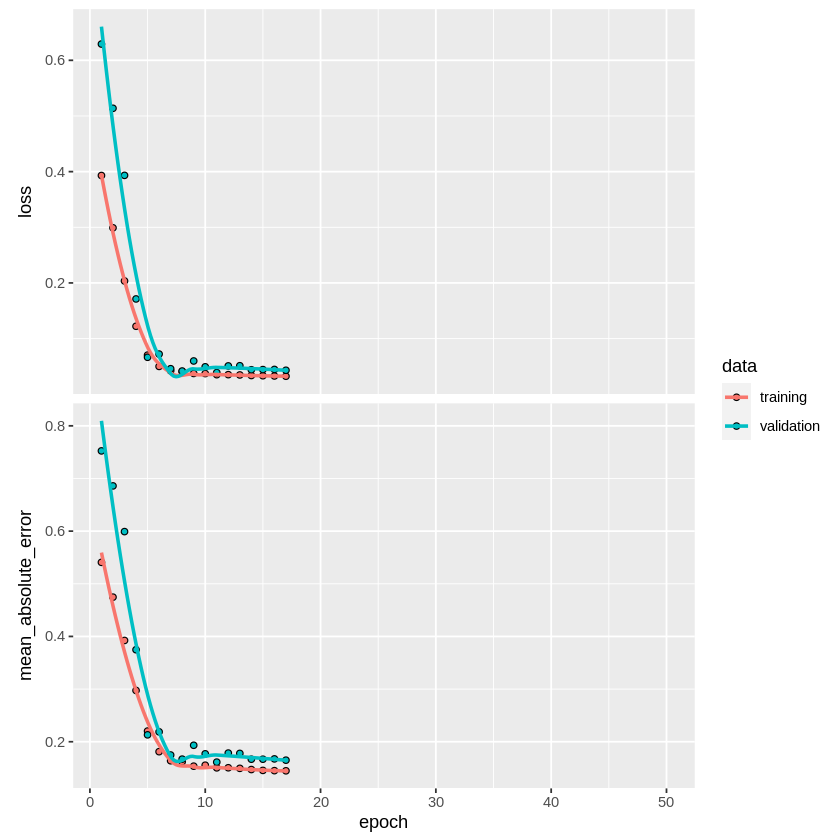

In [98]:
plot(models$model_1$history)

`geom_smooth()` using formula 'y ~ x'



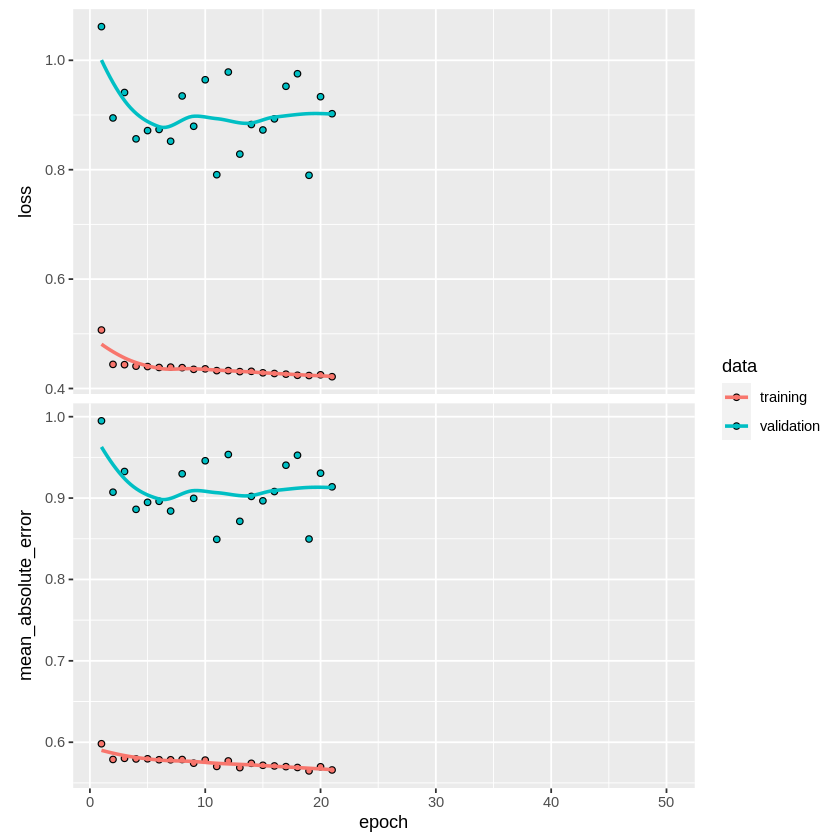

In [99]:
plot(models$model_4$history)

## Compare the performance

In [102]:
explainers = explain_models(models = models)

Preparation of a new explainer is initiated
  -> model label       :  Keras model 1 
  -> data              :  200  rows  8  cols 
  -> target variable   :  200  values 
  -> predict function  :  yhat.default will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package Model of class: keras.engine.sequential.Sequential package unrecognized , ver. Unknown , task regression (  default  ) 
  -> model_info        :  type set to  regression 
  -> predicted values  :  numerical, min =  -1.354079 , mean =  -0.01038824 , max =  1.171513  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -0.594088 , mean =  -0.01492621 , max =  0.4229347  
  A new explainer has been created!  
Preparation of a new explainer is initiated
  -> model label       :  Keras model 2 
  -> data              :  200  rows  8  cols 
  -> target variable   :  200  values 
  -

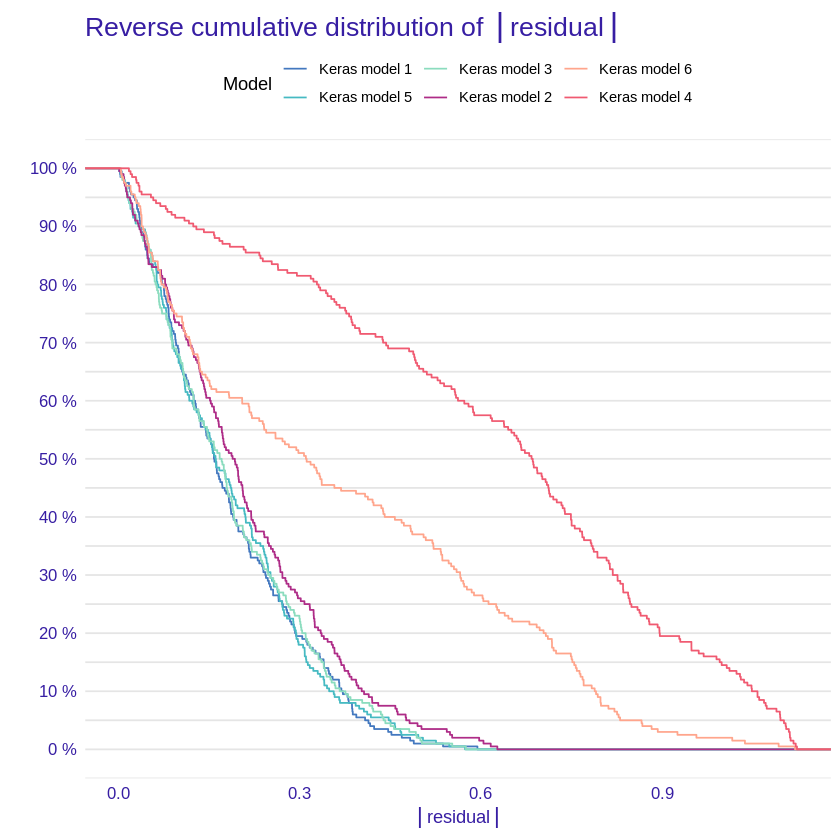

In [103]:
plot(explainers$model_performance_value)

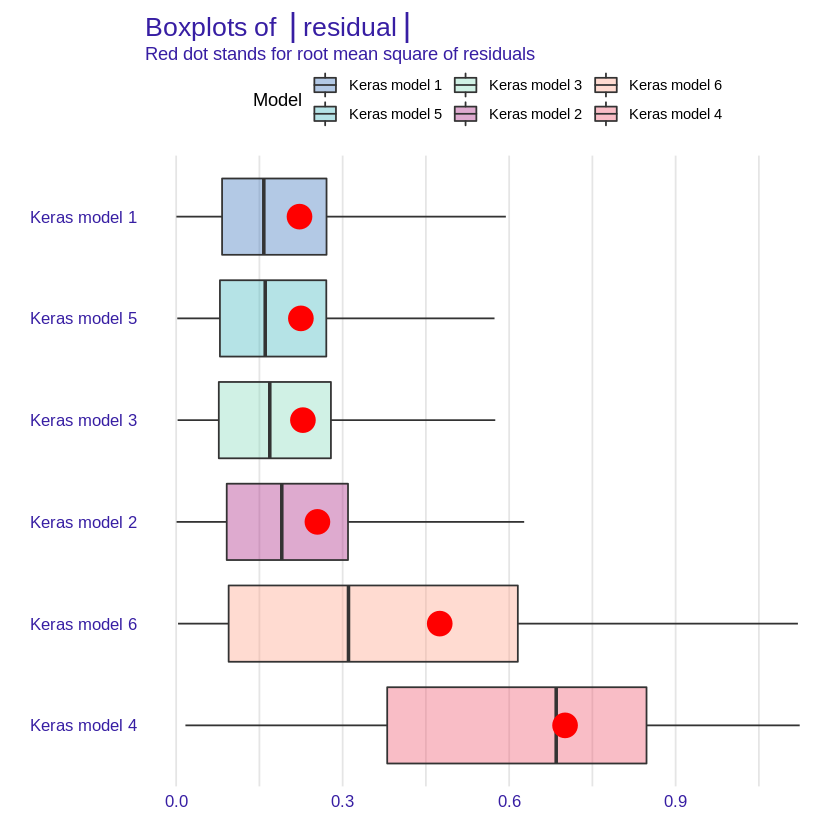

In [104]:
plot(explainers$model_performance_value, geom = "boxplot")

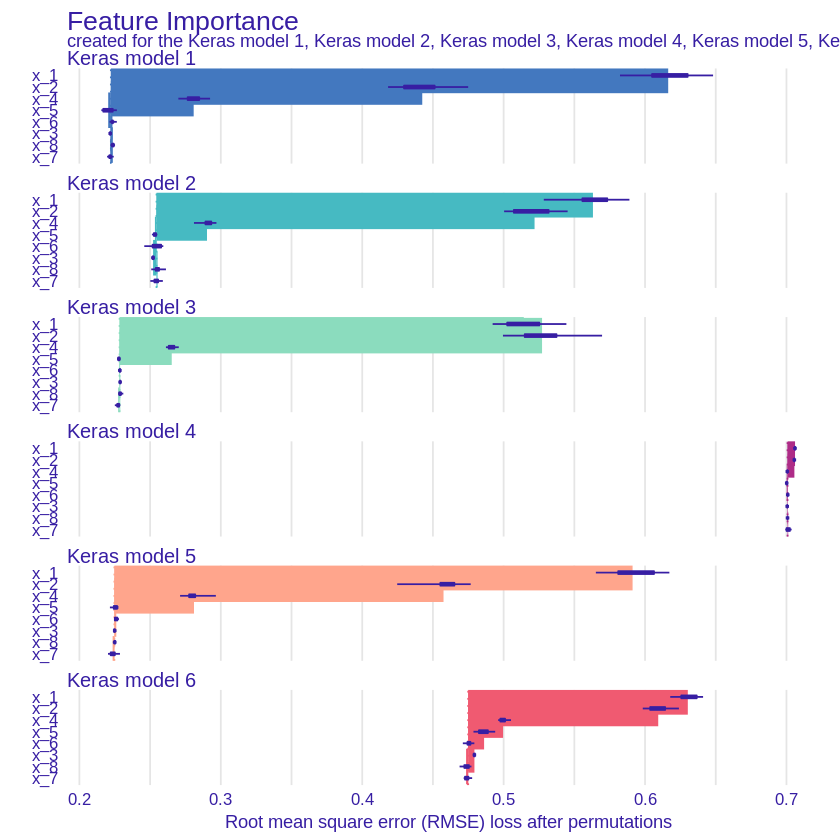

In [105]:
plot(explainers$model_parts_value)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



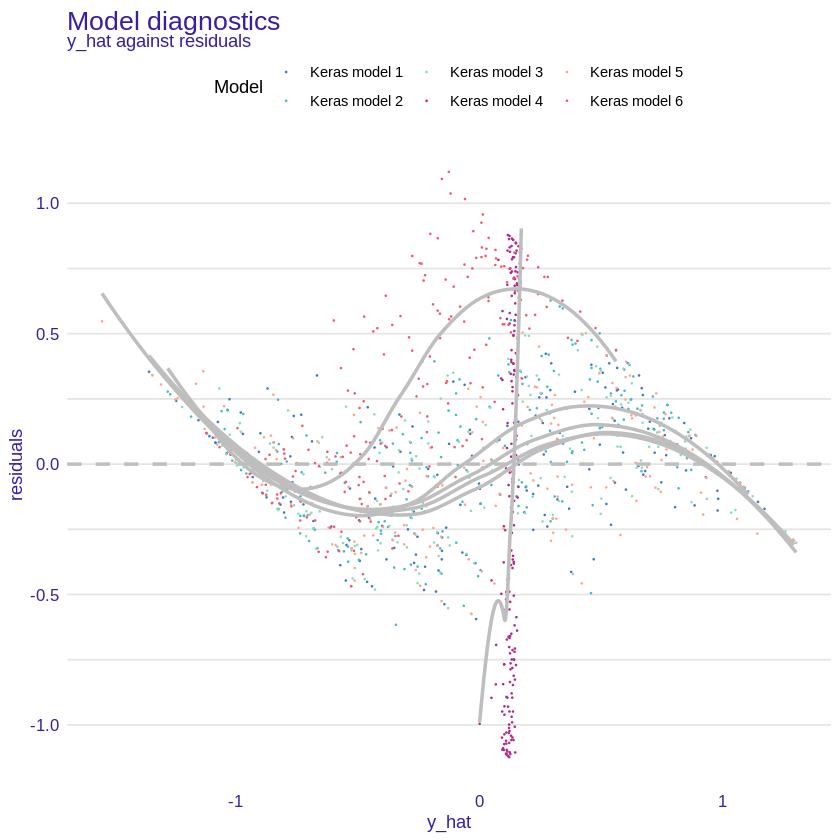

In [106]:
plot(explainers$model_diagnostics_value)

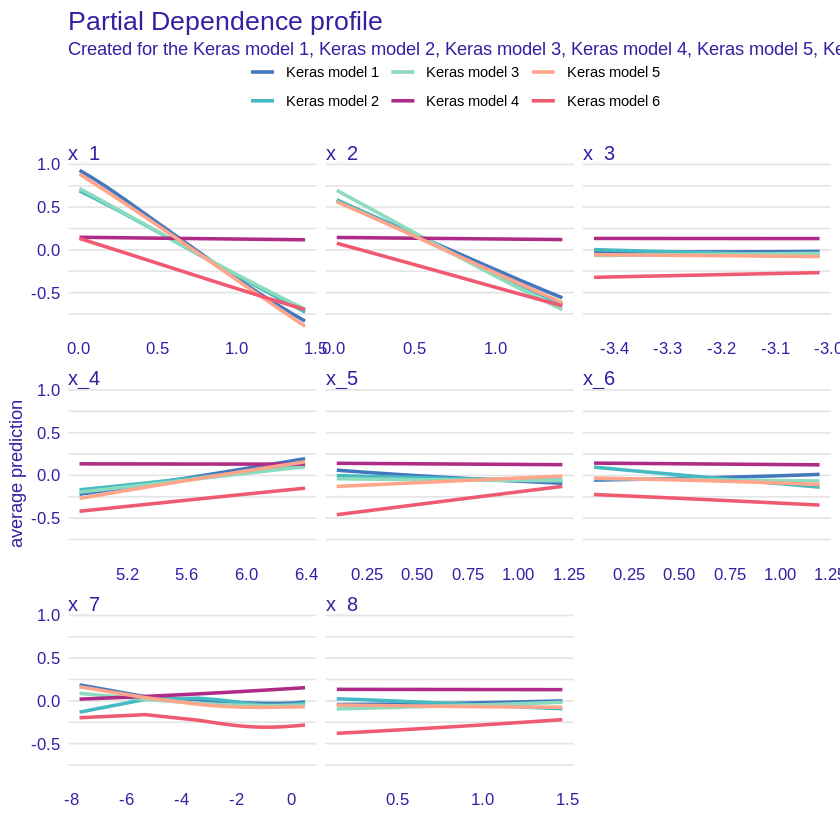

In [107]:
plot(explainers$model_profile_value)

So that would be it. Thank you very much for joining, I hope you learned some usefull stuff! 